In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
%pip install -Uq langgraph langgraph_sdk langchain_openai

Note: you may need to restart the kernel to use updated packages.


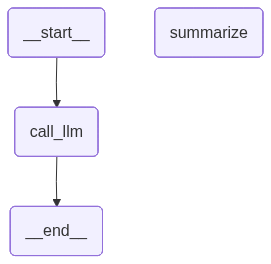

In [1]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
#from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
# llm = ChatGroq()

# state
class State(MessagesState):
    summary: str

# nodes
def call_llm(state: State):
    summary = state.get("summary", "")
    if summary:
        system_message = f"Summary of the conversation so far: {summary}"
        messages = [SystemMessage(system_message)] + state['messages']
    else:
        messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": response}

def summarize(state: State):
    summary = state.get("summary", "")
    if summary:
        summary_message = f"""
        Here is the summary of the conversation so far: {summary}
        Extend thi summary by taking into account the new messages above.
        """
    else:
        summary_message = "Create a summary of the conversation so far."

    messages = state['messages'] + [HumanMessage(summary_message)]
    generated_summary = llm.invoke(messages)

    delete_messages = [m for m in state['messages'][:-2]]
    return {"summary": generated_summary, "messages": delete_messages}

# conditional edge
def should_continue(state: State):
    messages = state.get("messages", [])
    if len(messages) > 6:
        return "summarize"
    return END

# graph
builder = StateGraph(State)
builder.add_node(call_llm)
builder.add_node(summarize)

builder.add_edge(START, "call_llm")
builder.add_conditional_edges("call_llm", should_continue)
builder.add_edge("summarize", END)

# memory and compile
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Streaming updates

Streams only the new data points to the client.

In [ ]:
config = {"configurable": {"thread_id": "11"}}

messages = [HumanMessage(content="how much is 5 times 4?")]

# each chunk is a new message that was streamed
for chunk in graph.stream(
      {"messages":messages}, config=config, stream_mode="updates"
    ):
    chunk['call_llm']['messages'].pretty_print()


================================== Ai Message ==================================

5 times 4 is 20.


In [3]:
# complete list of messages

for m in graph.get_state(config=config).values.get("messages", []):
    m.pretty_print()

================================ Human Message =================================

how much is 5 times 4?
================================== Ai Message ==================================

5 times 4 is 20.


## Streaming values

Each time, you receive an entire array of values.

In [4]:
config = {"configurable": {"thread_id": "2"}}

messages = [HumanMessage(content="how much is 2 times 10?")]

for chunk in graph.stream(
      {"messages":messages}, config=config, stream_mode="values"
    ):
    print("\n" + "#"*80 + "\n")
    for m in chunk['messages']:
        m.pretty_print()



################################################################################

================================ Human Message =================================

how much is 2 times 10?

################################################################################

================================ Human Message =================================

how much is 2 times 10?
================================== Ai Message ==================================

2 times 10 is 20.


In [5]:
for m in graph.get_state(config).values.get("messages"):
  m.pretty_print()

================================ Human Message =================================

how much is 2 times 10?
================================== Ai Message ==================================

2 times 10 is 20.


## Streaming tokens

check the code below. events that contain tokens are of type `on_chat_model_stream` and name`ChatGroq` (because we are usig Groq).

In [6]:
from pprint import pprint
config = {"configurable": {"thread_id": "9"}}

input_message = HumanMessage(content="how much is 2 times 10?")
async for event in graph.astream_events(
    {"messages":[input_message]},
    config,
    version="v2"
  ):
   print(event)
  #pprint(f"node: {event['metadata'].get('langgraph_node', '')}. type: {event['event']}. name: {event['name']}")

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='how much is 2 times 10?', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': '3ab13c81-c6bc-4052-bfd9-73776decfdc5', 'metadata': {'thread_id': '9'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='how much is 2 times 10?', additional_kwargs={}, response_metadata={}, id='a707f30b-8ea5-476a-b5e0-25d1f346813f')]}}, 'name': 'call_llm', 'tags': ['graph:step:1'], 'run_id': '48d4950e-0209-4ea5-9d99-5e9e2e415325', 'metadata': {'thread_id': '9', 'langgraph_step': 1, 'langgraph_node': 'call_llm', 'langgraph_triggers': ('branch:to:call_llm',), 'langgraph_path': ('__pregel_pull', 'call_llm'), 'langgraph_checkpoint_ns': 'call_llm:5e074ac2-0836-29bd-52c0-4153b7e17a37'}, 'parent_ids': ['3ab13c81-c6bc-4052-bfd9-73776decfdc5']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='how much is 2 tim

In [7]:
config = {"configurable": {"thread_id": "321"}}

input_message = HumanMessage(content="how much is 2 times 10?")
async for event in graph.astream_events(
  {"messages":[input_message]},
  config,
  version="v2"
  ):
  if event['event'] == "on_chat_model_stream":
    # event['data'] contains a chunk
    print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--752f5000-e9c0-4d28-b2bf-48284cd0d5f6')}
{'chunk': AIMessageChunk(content='2', additional_kwargs={}, response_metadata={}, id='run--752f5000-e9c0-4d28-b2bf-48284cd0d5f6')}
{'chunk': AIMessageChunk(content=' times', additional_kwargs={}, response_metadata={}, id='run--752f5000-e9c0-4d28-b2bf-48284cd0d5f6')}
{'chunk': AIMessageChunk(content=' ', additional_kwargs={}, response_metadata={}, id='run--752f5000-e9c0-4d28-b2bf-48284cd0d5f6')}
{'chunk': AIMessageChunk(content='10', additional_kwargs={}, response_metadata={}, id='run--752f5000-e9c0-4d28-b2bf-48284cd0d5f6')}
{'chunk': AIMessageChunk(content=' is', additional_kwargs={}, response_metadata={}, id='run--752f5000-e9c0-4d28-b2bf-48284cd0d5f6')}
{'chunk': AIMessageChunk(content=' ', additional_kwargs={}, response_metadata={}, id='run--752f5000-e9c0-4d28-b2bf-48284cd0d5f6')}
{'chunk': AIMessageChunk(content='20', additional_kwargs={}, response_metada

In [8]:
input_message = HumanMessage(content="tell me a story about a king and a princess")
async for event in graph.astream_events(
  {"messages":[input_message]},
  config,
  version="v2"
  ):
  if event['event'] == "on_chat_model_stream":
    # stream the content of the chunk
    print(event["data"].get("chunk").content, end="")

Once upon a time, in a kingdom nestled between lush green hills and sparkling rivers, there lived a wise and benevolent king named King Alaric. He ruled the land of Eldoria with kindness and fairness, and his people adored him. The kingdom thrived under his reign, and peace reigned for many years.

King Alaric had a daughter named Princess Elara, a spirited young woman with a heart full of dreams. She was known throughout the kingdom for her beauty, intelligence, and compassion. Elara often wandered through the villages, listening to the stories of her people and helping those in need. She longed for adventure beyond the castle walls, dreaming of exploring the world and making a difference.

One day, while walking in the royal gardens, Elara stumbled upon an ancient, weathered map hidden beneath a stone. Intrigued, she carefully unfolded it and discovered it depicted a hidden treasure located deep within the Enchanted Forest, a mystical place said to be filled with magical creatures an

In [9]:
for m in graph.get_state(config).values.get("messages"):
  m.pretty_print()

================================ Human Message =================================

how much is 2 times 10?
================================== Ai Message ==================================

2 times 10 is 20.
================================ Human Message =================================

tell me a story about a king and a princess
================================== Ai Message ==================================

Once upon a time, in a kingdom nestled between lush green hills and sparkling rivers, there lived a wise and benevolent king named King Alaric. He ruled the land of Eldoria with kindness and fairness, and his people adored him. The kingdom thrived under his reign, and peace reigned for many years.

King Alaric had a daughter named Princess Elara, a spirited young woman with a heart full of dreams. She was known throughout the kingdom for her beauty, intelligence, and compassion. Elara often wandered through the villages, listening to the stories of her people and helping those in